## Libraries

In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import yaml
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings("ignore")
import seaborn as sns
from settings import (
    SPEED_DATA_PATH,
    WIND_DATA_PATH, 
    GEO_PATH
)
from sz.SZ3.tools.pysz.pysz import SZ
from compress.sprintz_encode import compress_sprintz, decompress_sprintz, get_compress_info_sprintz
from compress.bypass import spatial_clustering
from compress.general_functions import get_errors, get_geo_dict, create_geo_plot
from compress.xor_encode import xor_compress_df, get_compress_info_xor, decompress_xor_df
from compress.lz4_encode import LZ4_compress_df, LZ4_decompress_df, get_compress_info_lz4
from compress.spatial_lz4 import spatial_clustering_PCA_LZ4, spatial_lz4_decompress, get_compress_info_spatial_PCA_LZ4, lz4_one
from compress.spatial_xor import spatial_clustering_xor, spatial_XOR_decompress, get_compress_info_spatial_xor
from compress.spatial_sprintz import spatial_clustering_sprintz, spatial_sprintz_decompress, get_compress_info_spatial_sprintz
from compress.sz3_encode import compress_sz3_df, decompress_sz3, get_compress_info_sz3, compress_sz3_all
from compress.cnn_encode import compress_cnn_sz3, decomress_cnn_sz3, get_compress_info_cnn_sz3, compress_cnn_cluster
from memory_profiler import memory_usage

## Params

In [64]:
table_params = [{
                'selector': 'caption',
                'props': [
                    ('color', 'Blue'),
                    ('font-size', '16pt'),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('caption-side', 'top'),
                    ('padding', '10px')
                ]
            },
            {
                'selector': 'th',
                'props': [('font-size', '14pt')]
            }]

In [65]:
time_dict = {}
mem_dict = {}

## Data

### Download dataset

In [66]:
# int time series
speed_init = pd.read_csv(SPEED_DATA_PATH, parse_dates=[0], index_col=[0])# данные заполненности дорог
speed_init.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2015-08-31 18:22:00 to 2015-09-17 16:24:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2500 non-null   int64
dtypes: int64(1)
memory usage: 39.1 KB


In [67]:
speed_init['index'] = np.arange(speed_init.shape[0])
sensor_data = {}

for i in range(5):
    sensor_data[f'sensor_{i+1}'] = speed_init.loc[speed_init['index'] % 5 == i,
                                             ['value']]['value'].to_list()

df_speed = pd.DataFrame(sensor_data)
print('DataFrame shape:', df_speed.shape)
df_speed.head()

DataFrame shape: (500, 5)


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,90,80,84,94,90
1,91,62,96,75,84
2,86,93,69,88,71
3,74,68,88,71,87
4,82,68,73,69,57


In [68]:
df_speed.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,82.126000,81.538000,81.862000,81.786000,82.222000
std,8.404963,9.247897,8.155488,8.913085,8.983659
min,43.000000,28.000000,53.000000,29.000000,20.000000
25%,77.000000,76.000000,77.000000,76.000000,77.000000
50%,83.000000,82.000000,82.000000,82.000000,83.000000
75%,87.000000,88.000000,87.000000,88.000000,88.000000
max,109.000000,103.000000,106.000000,106.000000,105.000000


In [69]:
df_wind = pd.read_csv(WIND_DATA_PATH)
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  5371 non-null   float64
 1   sensor_1  5371 non-null   float64
 2   sensor_2  5371 non-null   float64
 3   sensor_3  5371 non-null   float64
 4   sensor_4  5371 non-null   float64
 5   sensor_5  5371 non-null   float64
dtypes: float64(6)
memory usage: 251.9 KB


In [70]:
df_wind.describe()

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000
mean,0.227920,0.200216,0.250895,0.226237,0.210789,0.170282
std,0.183147,0.194221,0.228161,0.186192,0.204030,0.158362
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.071329,0.035002,0.043961,0.067200,0.037736,0.035301
50%,0.186014,0.139327,0.182703,0.176465,0.142235,0.121945
75%,0.370629,0.323170,0.428663,0.364866,0.348337,0.278338
max,0.683916,0.783491,0.871451,0.709350,0.791937,0.655671


### Creating wind Dataset

Возьмем данные о первых шести ветренных вышек.

In [71]:
# df_wind = df_wind_init[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']]
# df_wind = df_wind.head(10000)

Видим, что данные ненулевые через определенные промежутки времени. Это связано с тем, что отсутствует непрерывность замеров данных. Оставим только те строки, где есть хотя бы одно ненулевое значение.

In [72]:
# Ensure the correct columns are used
# df_wind = df_wind.loc[(
#     df_wind[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']] != 0).any(axis=1)].reset_index(drop=True)
# df_wind.columns = [f'sensor_{i}' for i in range(df_wind.shape[1])]
# df_wind.info()

In [73]:
#df_wind.to_csv('data/wind_df.csv', index=False) # save test dataframe

## Data analisys

In [74]:
corr_wind = df_wind.corr()
styled_corr_wind = corr_wind.style.set_caption("Correlation matrix of Emhires Dataset") \
                                  .background_gradient(cmap='coolwarm') \
                                  .set_properties(**{'font-size': '14pt'}) \
                                  .set_table_styles(table_params)

# Отображение матрицы корреляции
display(styled_corr_wind)

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
sensor_0,1.000000,0.692844,0.718031,0.858738,0.901123,0.844601
sensor_1,0.692844,1.000000,0.533855,0.723919,0.705373,0.862921
sensor_2,0.718031,0.533855,1.000000,0.637662,0.685302,0.661292
sensor_3,0.858738,0.723919,0.637662,1.000000,0.772007,0.839008
sensor_4,0.901123,0.705373,0.685302,0.772007,1.000000,0.884198
sensor_5,0.844601,0.862921,0.661292,0.839008,0.884198,1.000000


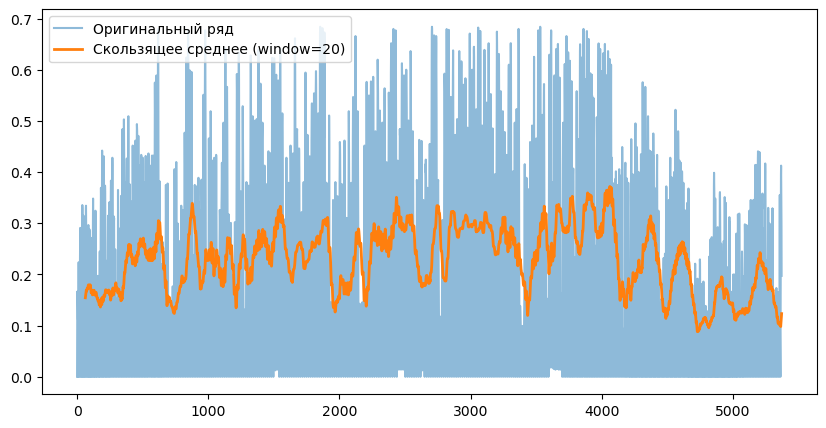

In [75]:
rolling_mean = df_wind.sensor_0.rolling(window=64).mean()

plt.figure(figsize=(10,5))
plt.plot(df_wind.sensor_0.values, label="Оригинальный ряд", alpha=0.5)
plt.plot(rolling_mean, label="Скользящее среднее (window=20)", linewidth=2)
plt.legend()
plt.show()

## Geo data

### For NAB

In [76]:
# # create for speed
# def get_geo_dict(df):
#     # make geo data
#     sen_num = df.shape[1]
#     x_y = []
#     for i in range(sen_num):
#         x_y.append([rn.uniform(.0, 6.0), rn.uniform(.0, 6.0)])
#         print(f'sensor_{i}:', x_y[i])
#     plt.grid(True)
#     for i in range(len(x_y)):
#         plt.plot(x_y[i][0], x_y[i][1], 'o', label = i)
#         plt.legend(loc = 'best', fancybox = True, shadow = True)
#     plt.plot(3*np.ones(300), np.arange(0, 6, 0.02))
#     plt.plot(np.arange(0, 6, 0.02), 3*np.ones(300))
#     geo_dict = dict(zip(df.columns, x_y))
#     print(geo_dict)
#     return dict(zip(df.columns, x_y))

sensor_0: [4.088250477864553, 5.822611642100302]
sensor_1: [4.386337615415687, 4.212615695519972]
sensor_2: [1.1073097267296637, 2.732845047538982]
sensor_3: [5.605800961352862, 3.6554528973395204]
sensor_4: [4.4223258904425595, 3.9480078433857235]


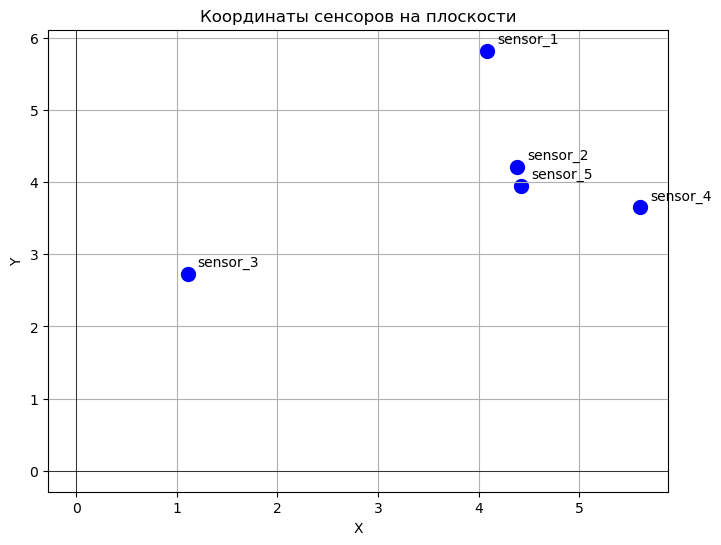

In [77]:
speed_geo_dict = get_geo_dict(df_speed)
create_geo_plot(speed_geo_dict)

### For wind

In [78]:
# create geo dict for wind dataset
# wind_geo_dict = get_geo_dict(df_wind)
# create_geo_plot(wind_geo_dict)

In [79]:
# print('Clusters for Emhires dataset:')
# spatial_clustering(df_wind, wind_geo_dict)

{'sensor_0': [1.1, 4.2], 'sensor_1': [4.3, 1.9], 'sensor_2': [5.1, 2.6], 'sensor_3': [0.5, 5.0], 'sensor_4': [1.2, 3.8], 'sensor_5': [2.12, 3.9]}


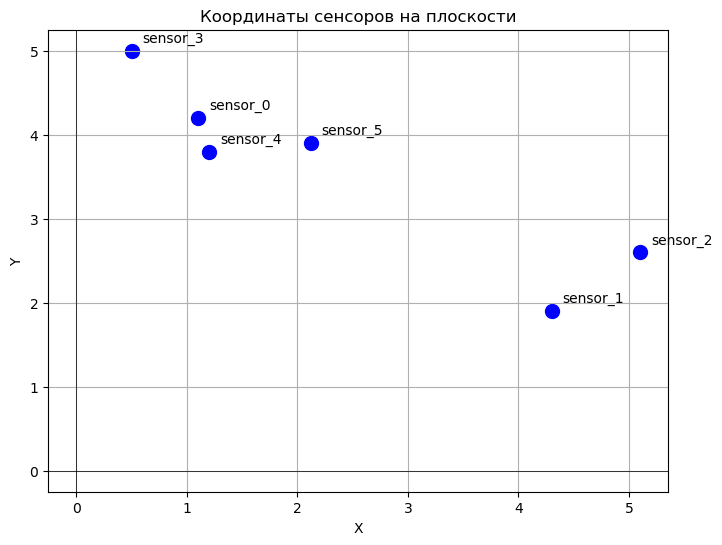

In [80]:
with open(GEO_PATH / 'wind_geo_dict.yaml', 'r') as file:
    wind_geo_dict = yaml.safe_load(file)

print(wind_geo_dict)
create_geo_plot(wind_geo_dict)

In [81]:
#check bypassing for clustering
print('Clusters for Emhires dataset:')
spatial_clustering(df_wind, wind_geo_dict)

Clusters for Emhires dataset:


{'sensor_0': ['sensor_0', 'sensor_4', 'sensor_3', 'sensor_5'],
 'sensor_1': ['sensor_1'],
 'sensor_2': ['sensor_2']}

## Sprintz

In [82]:
speed_sprintz_res = compress_sprintz(df=df_speed, chunk_size=8)

In [83]:
# Check for equals decodind and original data
decode_res = decompress_sprintz(speed_sprintz_res, num_cols = 5, chunk_size=7)
decode_res.columns = df_speed.columns
print('Check for decode:', df_speed.equals(decode_res))

Check for decode: True


In [84]:
get_compress_info_sprintz(df_speed, speed_sprintz_res)

Размер исходных данных: 2179 байт 

Размер сжатых данных: 1973 байт 

Коэффициент сжатия: 1.104


In [85]:
# #Рассмотрим количество используемой оперативной памяти и среднее время сжатия
# print('Compress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: compress_sprintz(df=df_speed, chunk_size=8), interval=0.0001)
# mem_dict['sprintz_enc'] = max(mem_usage) - baseline
# time_dict['sprintz_enc'] = %timeit -o compress_sprintz(df=df_speed, chunk_size=8)
# print('\n')
# #Рассмотрим количество используемой оперативной памяти и среднее время декодирования
# print('Decompress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: decompress_sprintz(speed_sprintz_res, num_cols = 5, chunk_size=7), interval=0.0001)
# mem_dict['sprintz_dec'] = max(mem_usage) - baseline
# time_dict['sprintz_dec'] = %timeit -o decompress_sprintz(speed_sprintz_res, num_cols = 5, chunk_size=7)

## XOR

In [86]:
compressed_df = xor_compress_df(df_wind)
decompressed_df = decompress_xor_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [87]:
get_compress_info_xor(df_wind, compressed_df)

Размер исходных данных: 257808 байт 

Размер сжатых XOR данных: 249461 байт 

Коэффициент сжатия: 1.033


In [88]:
# #Рассмотрим количество используемой оперативной памяти и среднее время сжатия
# print('Compress: \n')
# time_dict['xor_enc'] = %timeit -o xor_compress_df(df_wind)
# print('\n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: xor_compress_df(df_wind), interval=0.0001)
# mem_dict['xor_enc'] = max(mem_usage) - baseline
# #Рассмотрим количество используемой оперативной памяти и среднее время декодирования
# print('Decompress: \n')
# time_dict['xor_dec'] = %timeit -o decompress_xor_df(compressed_df)
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: decompress_xor_df(compressed_df), interval=0.0001)
# mem_dict['xor_dec'] = max(mem_usage) - baseline

## LZ4

In [89]:
compressed_df = LZ4_compress_df(df_wind)

In [90]:
decompressed_df = LZ4_decompress_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [91]:
get_compress_info_lz4(df_wind, compressed_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 191643 байт 

Коэффициент сжатия: 1.345


In [92]:
# #Рассмотрим количество используемой оперативной памяти и среднее время сжатия
# print('Compress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: LZ4_compress_df(df_wind), interval=0.00001)
# mem_dict['LZ4_enc'] = max(mem_usage) - baseline
# time_dict['LZ4_enc'] = %timeit -o LZ4_compress_df(df_wind)
# print('\n')
# #Рассмотрим количество используемой оперативной памяти и среднее время декодирования
# print('Decompress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: LZ4_decompress_df(compressed_df), interval=0.00001)
# mem_dict['LZ4_dec'] = max(mem_usage) - baseline
# time_dict['LZ4_dec'] = %timeit -o LZ4_decompress_df(compressed_df)

## Spatial + XOR

In [93]:
#todo solve problems where dif
df = df_wind.round(15).copy()

In [94]:
res = spatial_clustering_xor(df, wind_geo_dict)
decompressed_df = spatial_XOR_decompress(res)
print('Check for decode:', decompressed_df.equals(df))

Check for decode: True


In [95]:
get_compress_info_spatial_xor(df, res)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 255656.625 байт 

Коэффициент сжатия: 1.008


In [96]:
# #Рассмотрим количество используемой оперативной памяти и среднее время сжатия
# print('Compress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: spatial_clustering_xor(df, wind_geo_dict), interval=0.00001)
# mem_dict['spatial_xor_enc'] = max(mem_usage) - baseline
# time_dict['spatial_xor_enc'] = %timeit -o spatial_clustering_xor(df, wind_geo_dict)
# print('\n')
# #Рассмотрим количество используемой оперативной памяти и среднее время декодирования
# print('Decompress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: spatial_XOR_decompress(res), interval=0.00001)
# mem_dict['spatial_xor_dec'] = max(mem_usage) - baseline
# time_dict['spatial_xor_dec'] = %timeit -o spatial_XOR_decompress(res)

## Spatial + Sprintz

In [97]:
df = df_wind*100
df = df.astype(int)

In [98]:
res = spatial_clustering_sprintz(df.copy(), wind_geo_dict, 0.84)

In [99]:
clust_dict = spatial_clustering(
    df, wind_geo_dict, 0.84)
decode_res = spatial_sprintz_decompress(res,
                                        clust_dict)
print('Check for decode:', df.equals(decode_res))

Check for decode: True


In [100]:
get_compress_info_spatial_sprintz(df, res)

Размер исходных данных: 16428 байт 

Размер сжатых данных: 42420 байт 

Коэффициент сжатия: 0.387


In [101]:
# #Рассмотрим количество используемой оперативной памяти и среднее время сжатия
# print('Compress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: spatial_clustering_sprintz(df.copy(), wind_geo_dict, 0.84), interval=0.00001)
# mem_dict['spatial_sprintz_enc'] = max(mem_usage) - baseline
# time_dict['spatial_sprintz_enc'] = %timeit -o spatial_clustering_sprintz(df.copy(), wind_geo_dict, 0.84)
# print('\n')
# #Рассмотрим количество используемой оперативной памяти и среднее время декодирования
# print('Decompress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: spatial_sprintz_decompress(res, clust_dict), interval=0.00001)
# mem_dict['spatial_sprintz_dec'] = max(mem_usage) - baseline
# time_dict['spatial_sprintz_dec'] = %timeit -o spatial_sprintz_decompress(res, clust_dict)

## Spatial + PCA + LZ4

In [102]:
res = spatial_clustering_PCA_LZ4(df_wind, wind_geo_dict)

In [103]:
get_compress_info_spatial_PCA_LZ4(df_wind, res)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 148884 байт 

Коэффициент сжатия: 1.732


In [104]:
clusters = spatial_clustering(df_wind, wind_geo_dict)
dec_res = spatial_lz4_decompress(res, clusters)
get_errors(df_wind, dec_res)

MSE: 0.001079 

MAPE: 13.78 %


In [105]:
# #Рассмотрим количество используемой оперативной памяти и среднее время сжатия
# print('Compress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: spatial_clustering_PCA_LZ4(df_wind, wind_geo_dict), interval=0.00001)
# mem_dict['PCA_enc'] = max(mem_usage) - baseline
# time_dict['PCA_enc'] = %timeit -o spatial_clustering_PCA_LZ4(df_wind, wind_geo_dict)
# print('\n')
# #Рассмотрим количество используемой оперативной памяти и среднее время декодирования
# print('Decompress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: spatial_lz4_decompress(res, clusters), interval=0.00001)
# mem_dict['PCA_dec'] = max(mem_usage) - baseline
# time_dict['PCA_dec'] = %timeit -o spatial_lz4_decompress(res, clusters)

## SZ3

In [106]:
data_enc = compress_sz3_df(df_wind)

In [107]:
get_compress_info_sz3(df_wind, data_enc)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 12635 байт 

Коэффициент сжатия: 20.404


In [108]:
data = df_wind.values.transpose()
shape = [d.shape for d in data]
type = data[0].dtype
data_dec = decompress_sz3(data_enc, shape, type)
get_errors(df_wind, data_dec)

MSE: 0.000271 

MAPE: 20.64 %


In [109]:
# #Рассмотрим количество используемой оперативной памяти и среднее время сжатия
# print('Compress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: compress_sz3_df(df_wind), interval=0.00001)
# mem_dict['SZ3_enc'] = max(mem_usage) - baseline
# time_dict['SZ3_enc'] = %timeit -o compress_sz3_df(df_wind)
# print('\n')
# #Рассмотрим количество используемой оперативной памяти и среднее время декодирования
# print('Decompress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: decompress_sz3(data_enc, shape, type), interval=0.00001)
# mem_dict['SZ3_dec'] = max(mem_usage) - baseline
# time_dict['SZ3_dec'] = %timeit -o decompress_sz3(data_enc, shape, type)

In [110]:
# compress whole data
data = df_wind.values.transpose()
data_enc = compress_sz3_all(df_wind)

In [111]:
get_compress_info_sz3(df_wind, data_enc)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 11523 байт 

Коэффициент сжатия: 22.373


In [112]:
data_dec = decompress_sz3(data_enc, data.shape, data.dtype)
get_errors(df_wind, data_dec)

MSE: 0.000263 

MAPE: 22.64 %


## SZ3 + Conv

### Использование только данных главного сенсора.

Сожмем данные только кластера с помощью CNN и SZ3. Используем для сжатия модели алгоритм zstd.

Время обучения: 111.13 секунд


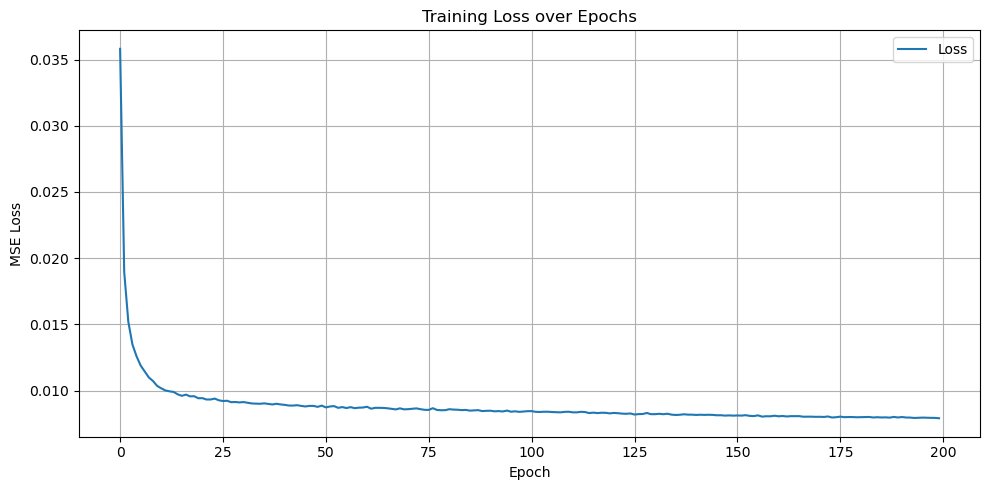

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5671891920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776807312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776807136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776807840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776806608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776808016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776808192: TensorSpec(shape=(), dtype=tf.resource, name=None)
Size of compressed model (bytes): 4111


W0000 00:00:1745445916.583810 15968800 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1745445916.583840 15968800 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-04-24 01:05:16.584286: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-24 01:05:16.585410: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-24 01:05:16.585427: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2025-04-24 01:05:16.601092: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-04-24 01:05:16.651833: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model
2025-04-24 01:05:16.670535: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 86252 microseconds.


In [113]:
cluster_enc = {}
cluster_sensors = ['sensor_0', 'sensor_3', 'sensor_4', 'sensor_5'] #выделяем коррелирующие сенсоры
cluster_enc[tuple(cluster_sensors)] = compress_cnn_cluster(df_wind[cluster_sensors], use_dwt=False,
                                                           window_size=64, num_epochs=200, plot_flag=True,
                                                           model_compress="zstd")

In [114]:
print('Сжатия кластера \n')
get_compress_info_cnn_sz3(df_wind[cluster_sensors], cluster_enc)

Сжатия кластера 

Размер исходных данных: 171872 байт 

Размер сжатых данных: 6617 байт 

Коэффициент сжатия: 25.974


In [115]:
dec_cluster_df = decomress_cnn_sz3(cluster_enc, (5371,), use_dwt=False, model_compress="zstd")
dec_cluster_df = dec_cluster_df.sort_index(axis=1)

In [116]:
get_errors(df_wind[cluster_sensors], dec_cluster_df)

MSE: 0.006077 

MAPE: 48.68 %


In [117]:
# cluster_enc_zstd = {}
# cluster_enc_lz4 = {}
# cluster_enc_zstd[tuple(cluster_sensors)] = compress_cnn_cluster(df_wind[cluster_sensors], use_dwt=False, window_size=64, num_epochs=70, 
#                                                            plot_flag=False, model_compress="zstd")
# cluster_enc_lz4[tuple(cluster_sensors)] = compress_cnn_cluster(df_wind[cluster_sensors], use_dwt=False, window_size=64, num_epochs=70, 
#                                                            plot_flag=False, model_compress="lz4")

# #Рассмотрим количество используемой оперативной памяти и среднее время сжатия
# print('Compress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: compress_cnn_cluster(df_wind[cluster_sensors], use_dwt=False,
#                                                       window_size=64, num_epochs=70, plot_flag=False,
#                                                       model_compress="zstd"), interval=1)
# mem_dict['SZ3_CNN_ZSTD_enc'] = max(mem_usage) - baseline
# time_dict['SZ3_CNN_ZSTD_enc'] = %timeit -o compress_cnn_cluster(df_wind[cluster_sensors], use_dwt=False, window_size=64, num_epochs=70, plot_flag=False, model_compress="zstd")
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: compress_cnn_cluster(df_wind[cluster_sensors], use_dwt=False,
#                                                       window_size=64, num_epochs=70,
#                                                       plot_flag=False, model_compress="lz4"), interval=1)
# mem_dict['SZ3_CNN_LZ4_enc'] = max(mem_usage) - baseline
# time_dict['SZ3_CNN_LZ4_enc'] = %timeit -o compress_cnn_cluster(df_wind[cluster_sensors], use_dwt=False, window_size=64, num_epochs=70, plot_flag=False, model_compress="lz4")
# print('\n')
# #Рассмотрим количество используемой оперативной памяти и среднее время декодирования
# print('Decompress: \n')
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: decomress_cnn_sz3(cluster_enc_zstd, (5371,),
#                                                    use_dwt=False, model_compress="zstd"), interval=1)
# mem_dict['SZ3_CNN_ZSTD_dec'] = max(mem_usage) - baseline
# time_dict['SZ3_CNN_ZSTD_dec'] = %timeit -o decomress_cnn_sz3(cluster_enc_zstd, (5371,), use_dwt=False, model_compress="zstd")
# baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
# mem_usage = memory_usage(lambda: decomress_cnn_sz3(cluster_enc_lz4, (5371,),
#                                                    use_dwt=False, model_compress="lz4"), interval=1)
# mem_dict['SZ3_CNN_LZ4_dec'] = max(mem_usage) - baseline
# time_dict['SZ3_CNN_LZ4_dec'] = %timeit -o decomress_cnn_sz3(cluster_enc_lz4, (5371,), use_dwt=False, model_compress="lz4")

Теперь сожмем все данные.

Время обучения: 32.91 секунд


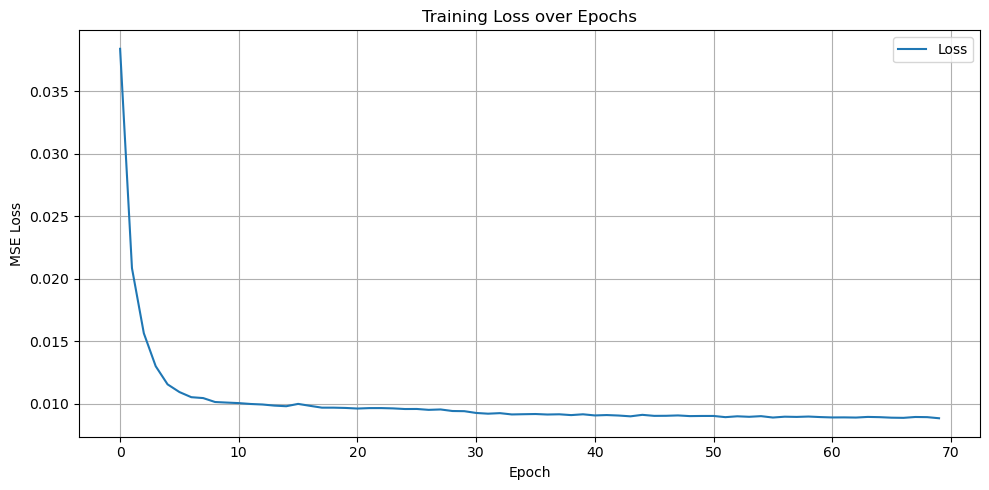

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name='keras_tensor_21')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5776808896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776816992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776812944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776810832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776810304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776816816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776811360: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1745445950.858792 15968800 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1745445950.858812 15968800 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


Size of compressed model (bytes): 4120


2025-04-24 01:05:50.859101: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-24 01:05:50.860029: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-24 01:05:50.860043: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2025-04-24 01:05:50.873765: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-04-24 01:05:50.922878: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model
2025-04-24 01:05:50.940718: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 81617 microseconds.


In [118]:
enc_df = compress_cnn_sz3(df_wind, wind_geo_dict, cor_lvl = 0.8, use_dwt=False, window_size=64, num_epochs=70, plot_flag=True)

In [119]:
get_compress_info_cnn_sz3(df_wind, enc_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 11024 байт 

Коэффициент сжатия: 23.386


In [120]:
dec_df = decomress_cnn_sz3(enc_df, (5371,), use_dwt=False)
dec_df = dec_df.sort_index(axis=1)

In [121]:
get_errors(df_wind, dec_df)

MSE: 0.004696 

MAPE: 49.75 %


### Добавление DWT.

Теперь будем использовать модель, выделяя дополнительные признаки - коэффициенты DWT.

Сожмем данные только кластера с помощью CNN и SZ3.

Epoch 1/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0382
Epoch 2/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0110
Epoch 3/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097
Epoch 4/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098
Epoch 5/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095
Epoch 6/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095
Epoch 7/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099
Epoch 8/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095
Epoch 9/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093
Epoch 10/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092
Epoch 11/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092
Epoch 12/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089
Epoch 13/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089
Epoch 14/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087
Epoch 15/200
332/332 ━━━━━━━━━━━━━━━━━━━━ 1

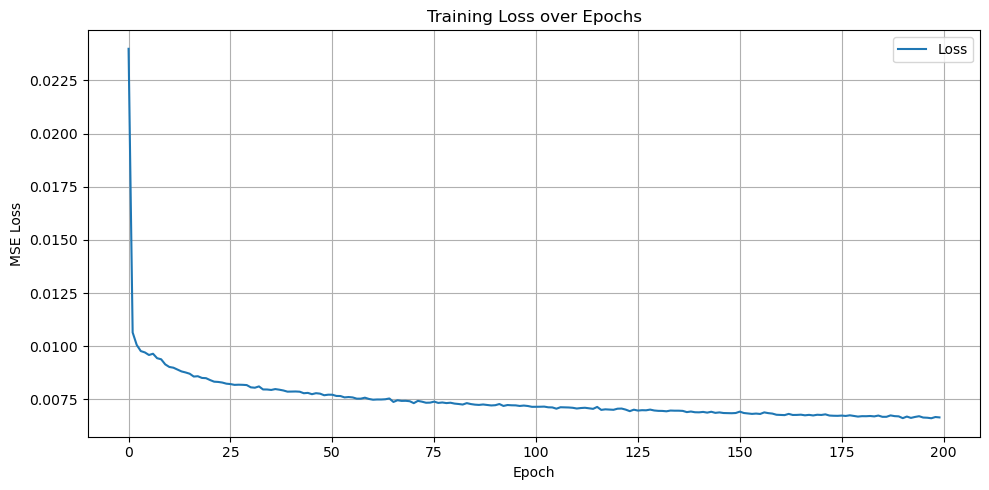

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name='seq_input'), TensorSpec(shape=(None, 77), dtype=tf.float32, name='dwt_input')]
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5776808544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776816640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776807664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776809952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776817872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776809776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776817696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5776816288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5778330320: TensorSpec(shape=(), dtype=tf.resource, name=None)
Size of compressed model (bytes): 23275


W0000 00:00:1745446073.604505 15968800 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1745446073.604526 15968800 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-04-24 01:07:53.604821: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-24 01:07:53.606137: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-24 01:07:53.606151: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2025-04-24 01:07:53.623972: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-04-24 01:07:53.685487: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model
2025-04-24 01:07:53.706132: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 101309 microseconds.


In [122]:
cluster_enc = {}
cluster_sensors = ['sensor_0', 'sensor_3', 'sensor_4', 'sensor_5'] #выделяем коррелирующие сенсоры
cluster_enc[tuple(cluster_sensors)] = compress_cnn_cluster(df_wind[cluster_sensors], use_dwt=True,
                                                           window_size=64, num_epochs=200, plot_flag=True)

In [123]:
print('Сжатия кластера \n')
get_compress_info_cnn_sz3(df_wind[cluster_sensors], cluster_enc)

Сжатия кластера 

Размер исходных данных: 171872 байт 

Размер сжатых данных: 25781 байт 

Коэффициент сжатия: 6.667


In [124]:
dec_cluster_df = decomress_cnn_sz3(cluster_enc, (5371,), use_dwt=True)
dec_cluster_df = dec_cluster_df.sort_index(axis=1)

In [125]:
get_errors(df_wind[cluster_sensors], dec_cluster_df)

MSE: 0.00518 

MAPE: 43.23 %


Теперь сожмем все данные.

Epoch 1/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0341
Epoch 2/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113
Epoch 3/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099
Epoch 4/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104
Epoch 5/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0094
Epoch 6/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094
Epoch 7/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093
Epoch 8/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092
Epoch 9/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094
Epoch 10/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092
Epoch 11/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082
Epoch 12/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083
Epoch 13/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088
Epoch 14/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089
Epoch 15/70
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

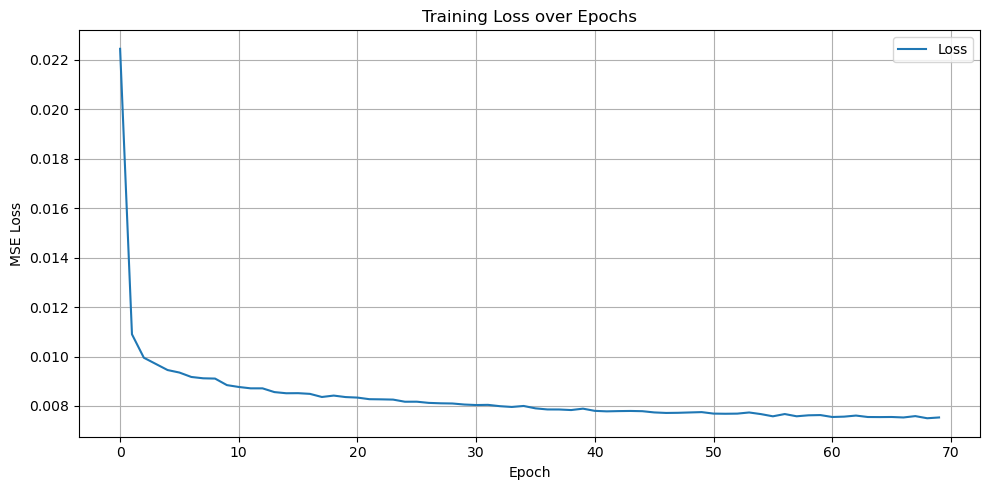

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name='seq_input'), TensorSpec(shape=(None, 77), dtype=tf.float32, name='dwt_input')]
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5778325744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5778331552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5778331200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5778326096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5778339120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5778329088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5778325920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5778332784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5778331728: TensorSpec(shape=(), dtype=tf.resource, name=None)
Size of compressed model (bytes): 26150


W0000 00:00:1745446131.863196 15968800 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1745446131.863212 15968800 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-04-24 01:08:51.863490: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-24 01:08:51.864613: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-24 01:08:51.864627: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2025-04-24 01:08:51.881602: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-04-24 01:08:51.941679: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model
2025-04-24 01:08:51.962144: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 98653 microseconds.


In [126]:
enc_df = compress_cnn_sz3(df_wind, wind_geo_dict, cor_lvl = 0.8, use_dwt=True, window_size=64, num_epochs=70, plot_flag=True, model_compress="lz4")

In [127]:
get_compress_info_cnn_sz3(df_wind, enc_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 33054 байт 

Коэффициент сжатия: 7.8


In [128]:
dec_df = decomress_cnn_sz3(enc_df, (5371,), use_dwt=True, model_compress="lz4")
dec_df = dec_df.sort_index(axis=1)

In [129]:
get_errors(df_wind, dec_df)

MSE: 0.003943 

MAPE: 37.83 %


## Time and memory usage

In [71]:
rows = []
for key, value in time_dict.items():
    mean = value.average
    std_dev = value.stdev
    rows.append({'Method': key, 'Mean (s)': mean, 'Std Dev (s)': std_dev})
time_df = pd.DataFrame(rows)
time_df.to_excel("time_usage.xlsx", index=False)
time_df

,Method,Mean (s),Std Dev (s)
0,sprintz_enc,0.207376,0.026185
1,sprintz_dec,0.109163,0.017483
2,xor_enc,0.171229,0.006939
3,LZ4_enc,0.000871,0.000078
4,LZ4_dec,0.000362,0.000001
5,spatial_xor_enc,0.147704,0.008136
6,spatial_xor_dec,0.265852,0.008654
7,spatial_sprintz_enc,2.287905,0.241062
8,spatial_sprintz_dec,1.277833,0.234049
9,PCA_enc,0.007192,0.001103


In [72]:
mem_df = pd.DataFrame(list(mem_dict.items()), columns=['Method', 'Memory Usage (MB)'])
mem_df.to_excel("mem_usage.xlsx", index=False)
mem_df

,Method,Memory Usage (MB)
0,sprintz_enc,-2.968750
1,sprintz_dec,0.042969
2,xor_enc,0.000000
3,xor_dec,0.007812
4,LZ4_enc,0.000000
5,LZ4_dec,0.000000
6,spatial_xor_enc,1.890625
7,spatial_xor_dec,0.085938
8,spatial_sprintz_enc,0.066406
9,spatial_sprintz_dec,0.261719
